In [1]:
import numpy as np
import matplotlib.pyplot as plt
import wobble

/Users/bfulton/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['figure.figsize'] = (12.0, 4.0)

#### You need data in a wobble-friendly format to load it in. See an example of this data munging here: [scripts/make_data.py](https://github.com/megbedell/wobble/blob/master/scripts/make_data.py).

You can download example HARPS data files (and results files) to play around with linked in the [documentation](https://wobble.readthedocs.io/en/latest/quickstart.html#input-data).

Here we'll assume that you have the data `51peg_e2ds.hdf5` saved in the `wobble/data` directory.

By default, loading the data will load all echelle orders and all epochs in the data file; you can change this with the optional `orders` and `epochs` kwargs, which each take lists (or 1-d numpy arrays) of indices for the desired orders/epochs to load.

In [4]:
data = wobble.Data('/Users/bfulton/Downloads/51peg_e2ds.hdf5')

/Users/bfulton/wobble/wobble/data.py:120: RuntimeWarning: invalid value encountered in multiply
  self.ivars = [self.fluxes[i]**2 * self.flux_ivars[i] for i in range(self.R)] # ivars for log(fluxes)


Behind the scenes, we have also continuum normalized and masked out regions of bad data (negative flux values or very low SNR regions). You may want to take a look at the data to see how we did:

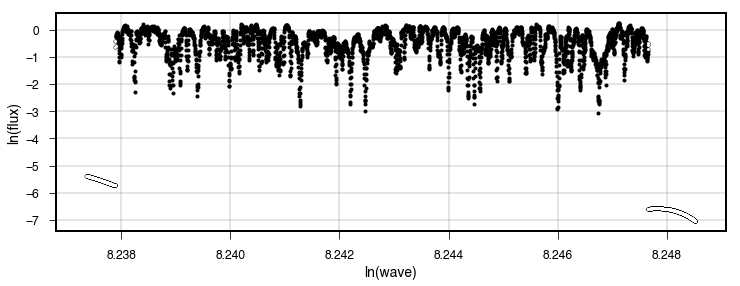

In [5]:
r = 0 # index of echelle order to plot
n = 0 # index of epoch to plot
plt.plot(data.xs[r][n], data.ys[r][n], 'k.', ms=6)
mask = data.ivars[r][n] <= 1.e-8 # masked-out bad data
plt.plot(data.xs[r][n][mask], data.ys[r][n][mask], 'w.', ms=4)
plt.ylabel('ln(flux)')
plt.xlabel('ln(wave)');

#### Now let's create a results object in which to store the outputs of wobble:

In [ ]:
results = wobble.Results(data=data)

This object is not currently populated with useful information (because we haven't optimized anything yet!), but once it is we'll be able to save it with the `results.write('filename.hdf5')` function.

A saved results file can be loaded as:
```results = wobble.Results(filename='filename.hdf5')```

### Here's a minimal example of optimizing a model consisting of a star and tellurics for a single order:

In [ ]:
r = 67 # index into data.orders for the desired order
model = wobble.Model(data, results, r)
model.add_star('star')
model.add_telluric('tellurics')
wobble.optimize_order(model)

The results have been automatically saved and we can now view them:

In [ ]:
n = 40 # epoch to plot
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[2, 1]}, 
                               sharex=True)

ax1.plot(data.xs[r][n], data.ys[r][n], 'k.', ms=6)
mask = data.ivars[r][n] <= 1.e-8 # masked-out bad data
ax1.plot(data.xs[r][n][mask], data.ys[r][n][mask], 'w.', ms=4)
ax1.plot(data.xs[r][n], results.star_ys_predicted[r][n], 'r')
ax1.plot(data.xs[r][n], results.tellurics_ys_predicted[r][n], 'b')
ax2.plot(data.xs[r][n], data.ys[r][n] - results.ys_predicted[r][n], 'k.', ms=6)
ax2.plot(data.xs[r][n][mask], (data.ys[r][n] - results.ys_predicted[r][n])[mask], 'w.', ms=4)

ax1.set_ylabel('ln(flux)')
ax2.set_ylabel('residuals')
#ax1.set_ylim([-0.2,0.1])
ax2.set_ylim([-0.05,0.05])
ax2.set_xlabel('ln(wave)');

The residuals look good for the star but not great around the tellurics. Let's try running with variable tellurics.

In [ ]:
results2 = wobble.Results(data=data)
model = wobble.Model(data, results2, r)
model.add_star('star')
model.add_telluric('tellurics', variable_bases=2)
wobble.optimize_order(model)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw = {'height_ratios':[2, 1]}, 
                               sharex=True)

ax1.plot(data.xs[r][n], data.ys[r][n], 'k.', ms=6)
mask = data.ivars[r][n] <= 1.e-8 # masked-out bad data
ax1.plot(data.xs[r][n][mask], data.ys[r][n][mask], 'w.', ms=4)
ax1.plot(data.xs[r][n], results2.star_ys_predicted[r][n], 'r')
ax1.plot(data.xs[r][n], results2.tellurics_ys_predicted[r][n], 'b')
ax2.plot(data.xs[r][n], data.ys[r][n] - results2.ys_predicted[r][n], 'k.', ms=6)
ax2.plot(data.xs[r][n][mask], (data.ys[r][n] - results2.ys_predicted[r][n])[mask], 'w.', ms=4)

ax1.set_ylabel('ln(flux)')
ax2.set_ylabel('residuals')
#ax1.set_ylim([-0.2,0.1])
ax2.set_ylim([-0.05,0.05])
ax2.set_xlabel('ln(wave)');

Looks better! Here are the RVs for this single order. Once we run on all orders, we can combine the order-by-order velocities using `results.combine_orders('star')` and access the final (non-barycentric-corrected RVs as `results.star_time_rvs`.

In [ ]:
plt.errorbar(results2.dates, results2.star_rvs[r] + results2.bervs, 
             1./np.sqrt(results2.star_ivars_rvs[r]), 
             fmt='o', ms=5, elinewidth=1)
plt.xlabel('JD')
plt.ylabel(r'RV (m s$^{-1}$)')
plt.xlim([2456505, 2456570]);

### Further exercises:
- run on all orders using the example on the [wobble quickstart page](https://wobble.readthedocs.io/en/latest/quickstart.html#running-wobble) or an example script (for many more figures) and look at the combined RVs
- [optimize the regularization amplitudes](https://github.com/megbedell/wobble/blob/master/scripts/regularization.py) and rerun
- check [the API](https://wobble.readthedocs.io/en/latest/api.html) and figure out what keywords to use if you want to:
    - change the limitations on "bad data" (which pixels will get masked out when reading in the data)
    - calculate uncertainties on the stellar template (warning: this will run slowly)
    - give your own custom starting RV guess to a component